In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.cross_validation import train_test_split
from models.cascade_base import CascadeBase
from utils.visualizer import Visualizer
from IPython.display import SVG, display

import numpy as np
import matplotlib.pyplot as plt

import time
import pydot
import lasagne

plt.style.use('ggplot')

%matplotlib notebook

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)
/home/apanin/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
def get_hex_color(layer_type):
    """
    Determines the hex color for a layer.
    :parameters:
        - layer_type : string
            Class name of the layer
    :returns:
        - color : string containing a hex color for filling block.
    """
    COLORS = ['#4A88B3', '#98C1DE', '#6CA2C8', '#3173A2', '#17649B',
              '#FFBB60', '#FFDAA9', '#FFC981', '#FCAC41', '#F29416',
              '#C54AAA', '#E698D4', '#D56CBE', '#B72F99', '#B0108D',
              '#75DF54', '#B3F1A0', '#91E875', '#5DD637', '#3FCD12']

    hashed = int(hash(layer_type)) % 5

    if "conv" in layer_type.lower():
        return COLORS[:5][hashed]
    if layer_type in lasagne.layers.pool.__all__:
        return COLORS[5:10][hashed]
    if layer_type in lasagne.layers.recurrent.__all__:
        return COLORS[10:15][hashed]
    else:
        return COLORS[15:20][hashed]

def make_pydot_graph(layers, output_shape=True, verbose=False):
    """
    :parameters:
        - layers : list
            List of the layers, as obtained from lasagne.layers.get_all_layers
        - output_shape: (default `True`)
            If `True`, the output shape of each layer will be displayed.
        - verbose: (default `False`)
            If `True`, layer attributes like filter shape, stride, etc.
            will be displayed.
    :returns:
        - pydot_graph : PyDot object containing the graph
    """

    pydot_graph = pydot.Dot('Network', graph_type='digraph')
    pydot_nodes = {}
    pydot_edges = []
    for i, layer in enumerate(layers):
        layer_type = '{0}'.format(layer.__class__.__name__)
        layer_name = layer.name if layer.name is not None else ''
        key = repr(layer)
        label = layer_name + ' ' + layer_type
        color = get_hex_color(layer_type)
        if verbose:
            for attr in ['num_filters', 'num_units', 'ds',
                         'filter_shape', 'stride', 'strides', 'p']:
                if hasattr(layer, attr):
                    label += '\n{0}: {1}'.format(attr, getattr(layer, attr))
            if hasattr(layer, 'nonlinearity'):
                try:
                    nonlinearity = layer.nonlinearity.__name__
                except AttributeError:
                    nonlinearity = layer.nonlinearity.__class__.__name__
                label += '\nnonlinearity: {0}'.format(nonlinearity)

        if output_shape:
            label += '\nOutput shape: {0}'.format(layer.output_shape)

        pydot_nodes[key] = pydot.Node(
            key, label=label, shape='record', fillcolor=color, style='filled')

        if hasattr(layer, 'input_layers'):
            for input_layer in layer.input_layers:
                pydot_edges.append([repr(input_layer), key])

        if hasattr(layer, 'input_layer'):
            pydot_edges.append([repr(layer.input_layer), key])

    for node in pydot_nodes.values():
        pydot_graph.add_node(node)

    for edges in pydot_edges:
        pydot_graph.add_edge(
            pydot.Edge(pydot_nodes[edges[0]], pydot_nodes[edges[1]]))
    return pydot_graph

def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt], targets[excerpt]


def learn(nn,
          dataset,
          watches=['obj',
                   'recall',
                   'precision',
                   'accuracy',
                   'loss',
                   'sub_loss'],
          num_epochs=100,
          batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    %matplotlib notebook
    
    X_train, X_val, y_train, y_val = dataset
    metrics_template = dict()
    
    metrics_sample = nn.evaluate(X_val[:2], y_val[:2])
    
    for metric_name, _ in metrics_sample.items():
        if metric_name == 'complexity_parts':
            metrics_template[metric_name] = [0] * len(metrics_sample[metric_name])
        else:
            metrics_template[metric_name] = 0
        
    visualizer = Visualizer(num_epochs,
                            metrics_template,
                            watches=watches)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        
        train_measurements = dict(metrics_template)
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.train(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        train_measurements[metric_name][j] += metric[j]
                else: 
                    train_measurements[metric_name] += metric

            train_batches += 1
            
        for metric_name, metric in train_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    train_measurements[metric_name][j] = metric[j] / train_batches
            else: 
                train_measurements[metric_name] = metric / train_batches

        # And a full pass over the validation data:
        val_measurements = dict(metrics_template)
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.evaluate(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        val_measurements[metric_name][j] += metric[j]
                else: 
                    val_measurements[metric_name] += metric

            val_batches += 1
            
        for metric_name, metric in val_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    val_measurements[metric_name][j] = metric[j] / val_batches
            else: 
                val_measurements[metric_name] = metric / val_batches

        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        visualizer.watch(train_measurements, val_measurements)
    visualizer.finish()
    
def draw(network):
    with open('../images/net.svg', 'w') as f:
        g = make_pydot_graph(lasagne.layers.get_all_layers(network))
        f.write(g.create_svg(f='svg'))

    display(SVG(filename='../images/net.svg'))

In [4]:
dataset = np.load('../data/X.npy')
targets = np.load('../data/targets.npy')

In [5]:
X_y = train_test_split(dataset.reshape(-1, 1, 200, 200).astype(np.float32),
                       targets.reshape(-1, 1, 200, 200).astype(np.float32))

# Simple network

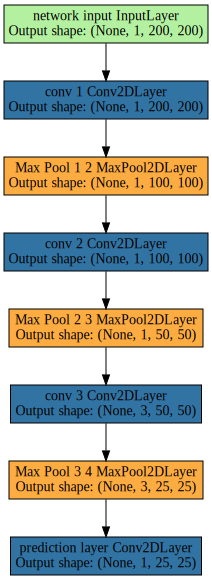

In [10]:
network = CascadeBase(img_shape=(200, 200),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[0, 0],
                      c_sub_obj_cs=[0, 0],
                      mul=False,
                      pool_sizes=[2, 2, 2],
                      num_filters=[1, 1, 3],
                      filter_sizes=[1, 3, 3])

draw(network.output_layer)

<IPython.core.display.Javascript object>


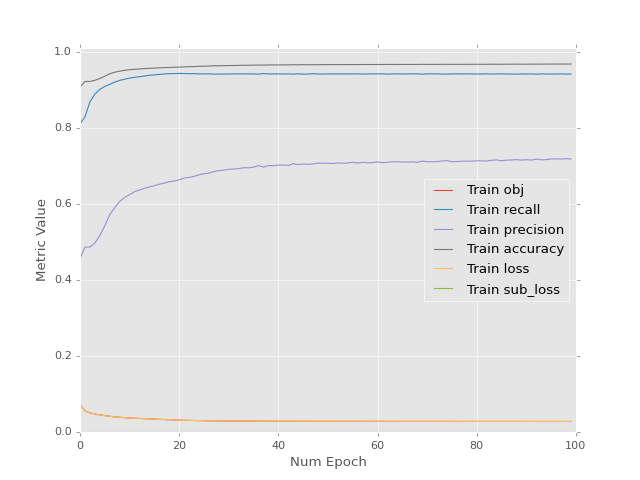

<IPython.core.display.Javascript object>


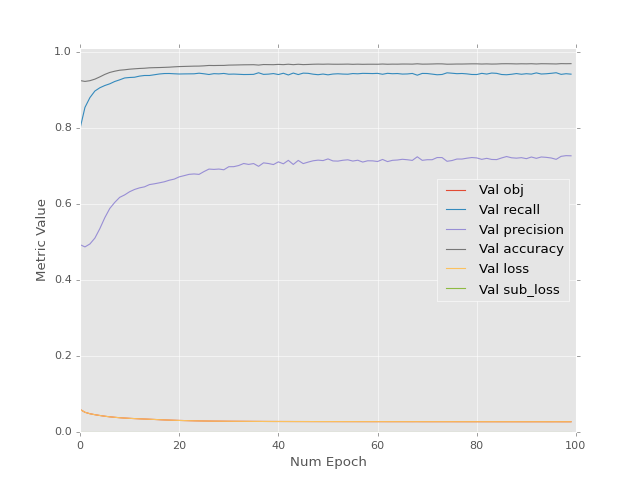

<IPython.core.display.Javascript object>


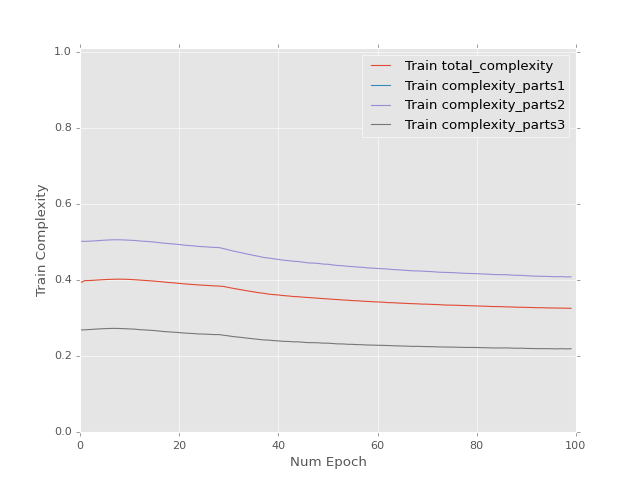

<IPython.core.display.Javascript object>


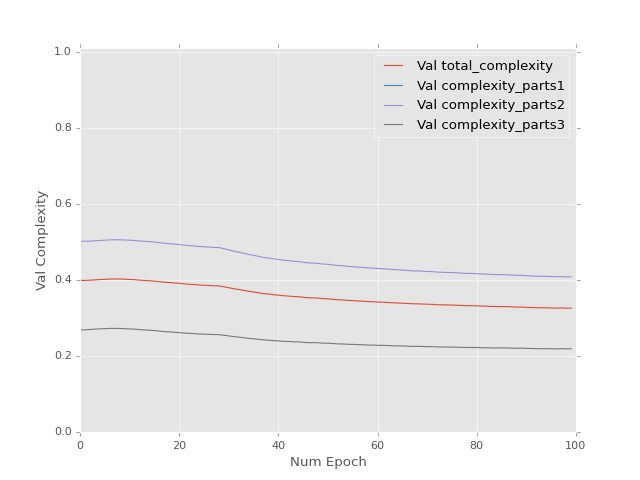

Epoch 1 of 100 took 15.588s
Epoch 2 of 100 took 15.844s
Epoch 3 of 100 took 15.772s
Epoch 4 of 100 took 15.713s
Epoch 5 of 100 took 15.587s
Epoch 6 of 100 took 15.583s
Epoch 7 of 100 took 15.839s
Epoch 8 of 100 took 15.720s
Epoch 9 of 100 took 15.852s
Epoch 10 of 100 took 15.469s
Epoch 11 of 100 took 15.720s
Epoch 12 of 100 took 15.894s
Epoch 13 of 100 took 15.886s
Epoch 14 of 100 took 15.856s
Epoch 15 of 100 took 15.765s
Epoch 16 of 100 took 15.807s
Epoch 17 of 100 took 15.775s
Epoch 18 of 100 took 15.910s
Epoch 19 of 100 took 15.958s
Epoch 20 of 100 took 15.806s
Epoch 21 of 100 took 15.846s
Epoch 22 of 100 took 15.884s
Epoch 23 of 100 took 15.959s
Epoch 24 of 100 took 15.528s
Epoch 25 of 100 took 15.912s
Epoch 26 of 100 took 15.749s
Epoch 27 of 100 took 15.732s
Epoch 28 of 100 took 15.728s
Epoch 29 of 100 took 15.826s
Epoch 30 of 100 took 15.729s
Epoch 31 of 100 took 15.983s
Epoch 32 of 100 took 15.740s
Epoch 33 of 100 took 15.815s
Epoch 34 of 100 took 15.700s
Epoch 35 of 100 took 15

In [11]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

# Improved network

## Sub objs

In [63]:
network = CascadeBase(img_shape=(200, 200),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[1e-2, 1e-1],
                      c_sub_obj_cs=[1e-3, 1e-2],
                      mul=False,
                      pool_sizes=[2, 2, 2],
                      num_filters=[1, 1, 3],
                      filter_sizes=[1, 3, 3])

<IPython.core.display.Javascript object>


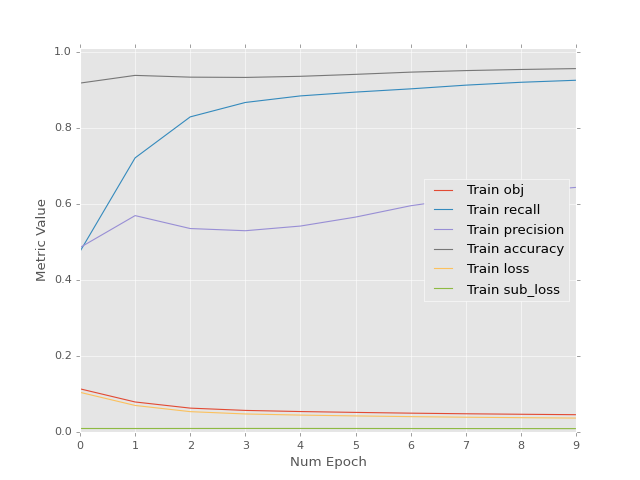

<IPython.core.display.Javascript object>


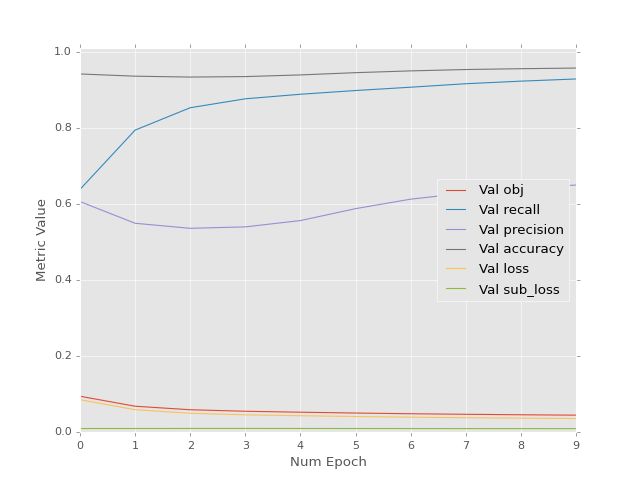

<IPython.core.display.Javascript object>


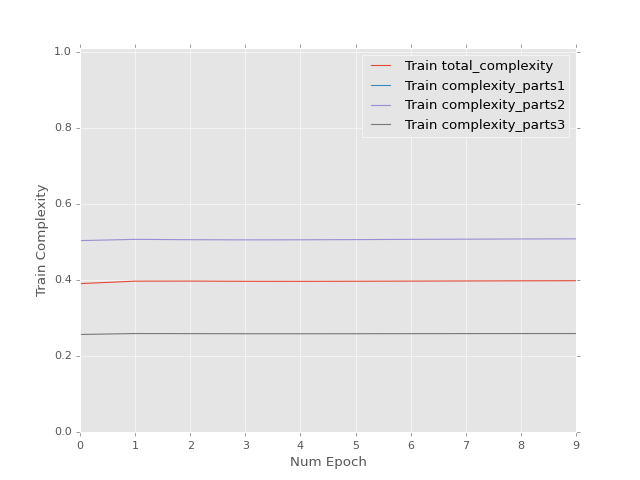

<IPython.core.display.Javascript object>


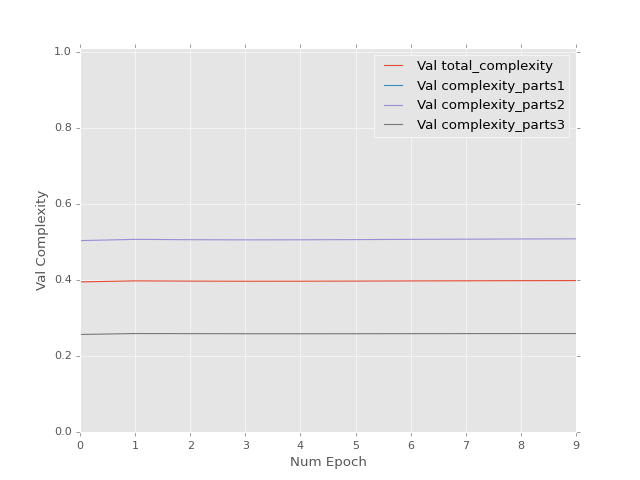

Epoch 1 of 10 took 15.075s
Epoch 2 of 10 took 15.602s
Epoch 3 of 10 took 15.296s
Epoch 4 of 10 took 15.241s
Epoch 5 of 10 took 14.966s
Epoch 6 of 10 took 15.650s
Epoch 7 of 10 took 15.644s
Epoch 8 of 10 took 15.646s
Epoch 9 of 10 took 15.577s
Epoch 10 of 10 took 15.052s


In [64]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=10,
      batch_size=50)

In [65]:
network.save('../weights', 'small_sub_obj')

## Increase importance of sub_obj and add multiplication

INFO (theano.gof.compilelock): Refreshing lock /home/apanin/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.2.1511-Core-x86_64-2.7.11-64/lock_dir/lock


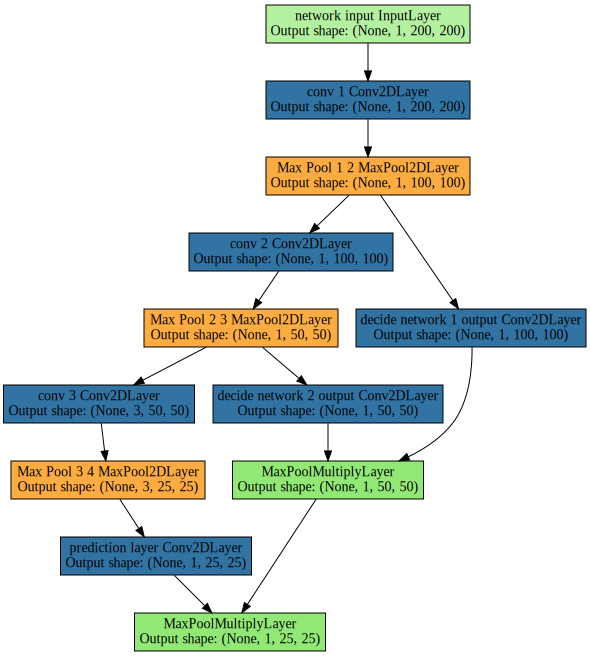

In [69]:
network = CascadeBase(img_shape=(200, 200),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[1e-1, 1],
                      c_sub_obj_cs=[1e-2, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2],
                      num_filters=[1, 1, 3],
                      filter_sizes=[1, 3, 3])
draw(network.output_layer)

In [70]:
network.load('../weights', 'small_sub_obj')

<IPython.core.display.Javascript object>


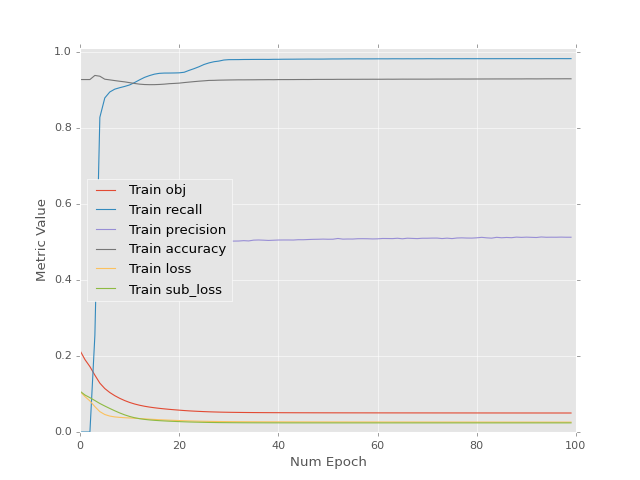

<IPython.core.display.Javascript object>


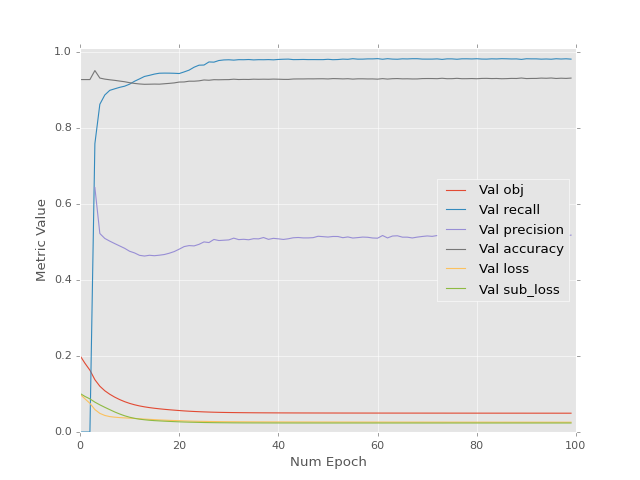

<IPython.core.display.Javascript object>


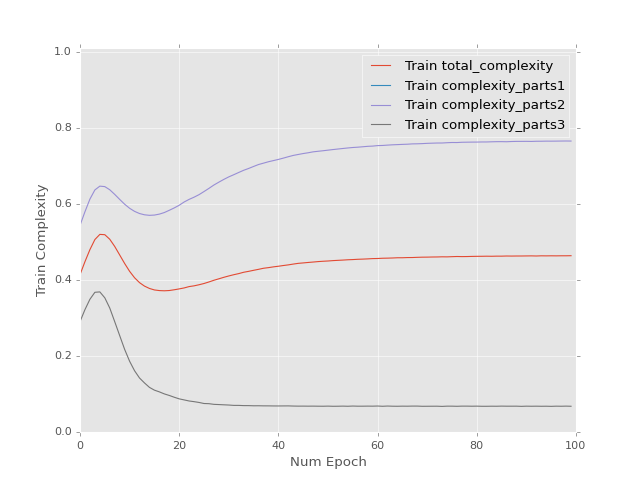

<IPython.core.display.Javascript object>


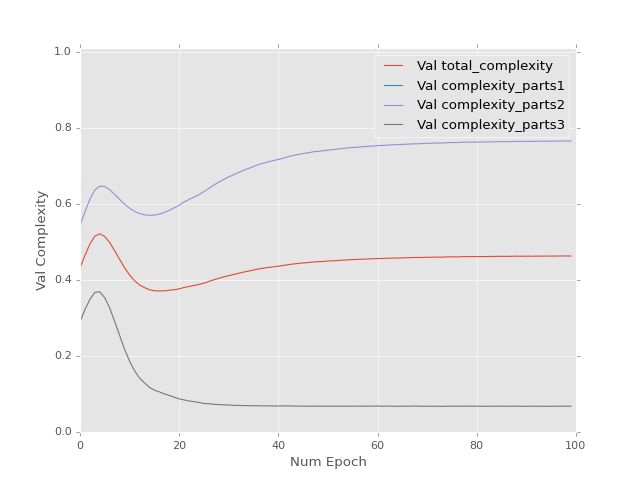

Epoch 1 of 100 took 20.124s
Epoch 2 of 100 took 19.822s
Epoch 3 of 100 took 19.890s
Epoch 4 of 100 took 20.061s
Epoch 5 of 100 took 19.876s
Epoch 6 of 100 took 20.034s
Epoch 7 of 100 took 19.922s
Epoch 8 of 100 took 20.024s
Epoch 9 of 100 took 20.165s
Epoch 10 of 100 took 20.133s
Epoch 11 of 100 took 20.142s
Epoch 12 of 100 took 20.047s
Epoch 13 of 100 took 19.739s
Epoch 14 of 100 took 19.372s
Epoch 15 of 100 took 20.177s
Epoch 16 of 100 took 20.119s
Epoch 17 of 100 took 20.198s
Epoch 18 of 100 took 19.773s
Epoch 19 of 100 took 20.143s
Epoch 20 of 100 took 20.072s
Epoch 21 of 100 took 20.209s
Epoch 22 of 100 took 20.092s
Epoch 23 of 100 took 20.132s
Epoch 24 of 100 took 20.146s
Epoch 25 of 100 took 19.954s
Epoch 26 of 100 took 20.086s
Epoch 27 of 100 took 19.848s
Epoch 28 of 100 took 19.821s
Epoch 29 of 100 took 19.665s
Epoch 30 of 100 took 20.078s
Epoch 31 of 100 took 19.965s
Epoch 32 of 100 took 19.779s
Epoch 33 of 100 took 20.190s
Epoch 34 of 100 took 19.987s
Epoch 35 of 100 took 19

In [71]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

In [72]:
network.save('../weights', 'mul_bigger_sub_obj')

## Add complexity and increase importance

In [76]:
network = CascadeBase(img_shape=(200, 200),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=1,
                      c_sub_objs=[1, 1],
                      c_sub_obj_cs=[1e-1, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2],
                      num_filters=[1, 1, 3],
                      filter_sizes=[1, 3, 3])

In [77]:
network.load('../weights', 'mul_bigger_sub_obj')

<IPython.core.display.Javascript object>


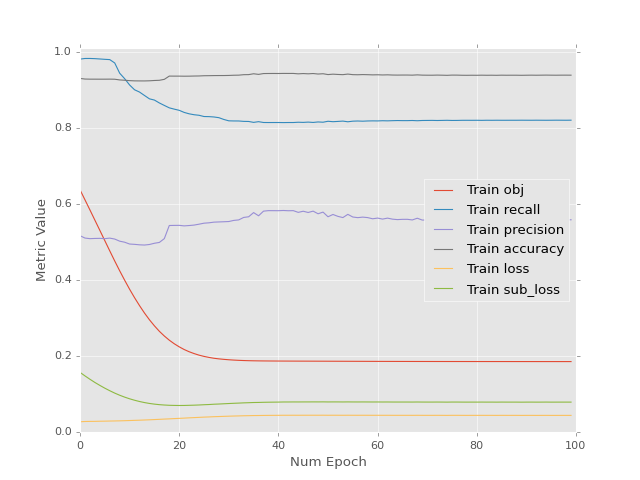

<IPython.core.display.Javascript object>


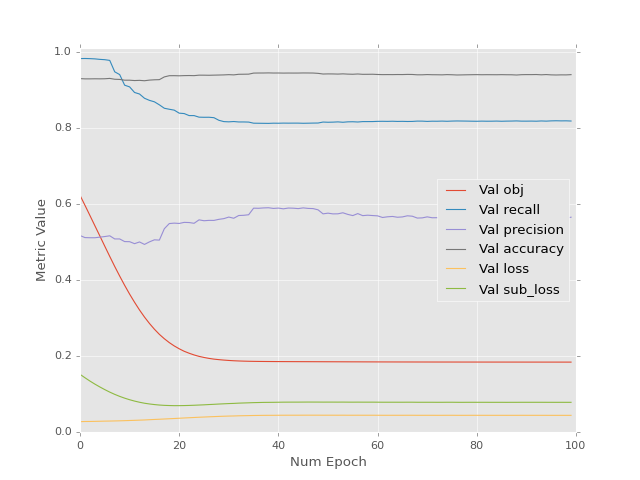

<IPython.core.display.Javascript object>


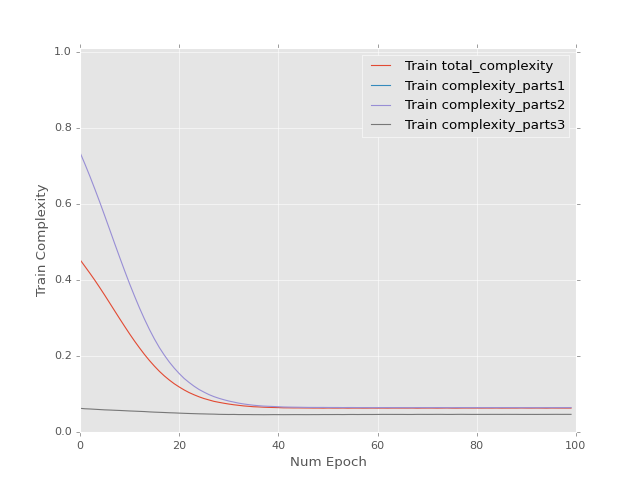

<IPython.core.display.Javascript object>


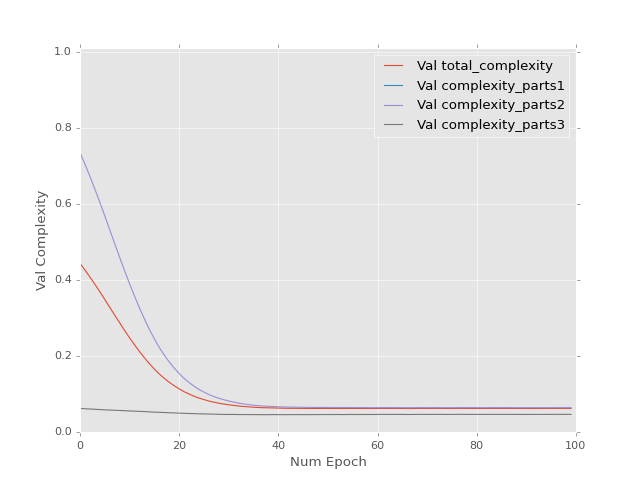

Epoch 1 of 100 took 20.179s
Epoch 2 of 100 took 20.320s
Epoch 3 of 100 took 20.260s
Epoch 4 of 100 took 20.385s
Epoch 5 of 100 took 20.269s
Epoch 6 of 100 took 20.377s
Epoch 7 of 100 took 20.390s
Epoch 8 of 100 took 20.400s
Epoch 9 of 100 took 20.301s
Epoch 10 of 100 took 20.386s
Epoch 11 of 100 took 20.375s
Epoch 12 of 100 took 20.104s
Epoch 13 of 100 took 20.397s
Epoch 14 of 100 took 20.354s
Epoch 15 of 100 took 20.382s
Epoch 16 of 100 took 20.333s
Epoch 17 of 100 took 20.331s
Epoch 18 of 100 took 20.365s
Epoch 19 of 100 took 20.154s
Epoch 20 of 100 took 20.340s
Epoch 21 of 100 took 20.134s
Epoch 22 of 100 took 20.137s
Epoch 23 of 100 took 20.319s
Epoch 24 of 100 took 20.354s
Epoch 25 of 100 took 20.356s
Epoch 26 of 100 took 20.263s
Epoch 27 of 100 took 20.343s
Epoch 28 of 100 took 20.348s
Epoch 29 of 100 took 20.259s
Epoch 30 of 100 took 20.316s
Epoch 31 of 100 took 20.367s
Epoch 32 of 100 took 20.217s
Epoch 33 of 100 took 20.232s
Epoch 34 of 100 took 20.296s
Epoch 35 of 100 took 20

In [78]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

In [80]:
network.save('../weights', 'mul_big_sub_obj_complex')

## Adjust coefficients

In [12]:
network = CascadeBase(img_shape=(200, 200),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=5e-1,
                      c_sub_objs=[5e-1, 1],
                      c_sub_obj_cs=[1e-2, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2],
                      num_filters=[1, 1, 3],
                      filter_sizes=[1, 3, 3])

In [13]:
network.load('../weights', 'mul_big_sub_obj_complex')

<IPython.core.display.Javascript object>


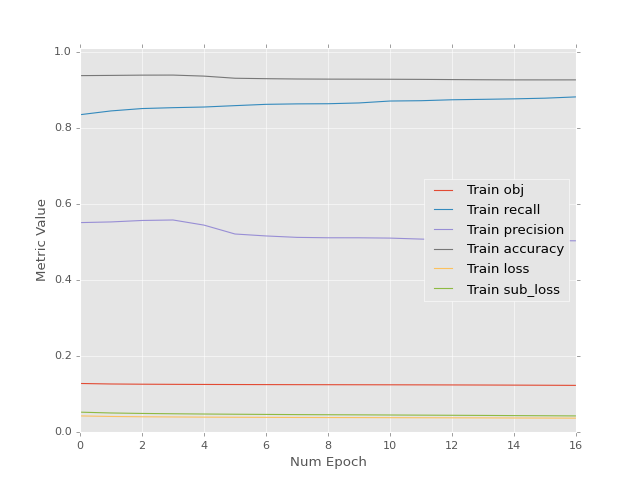

<IPython.core.display.Javascript object>


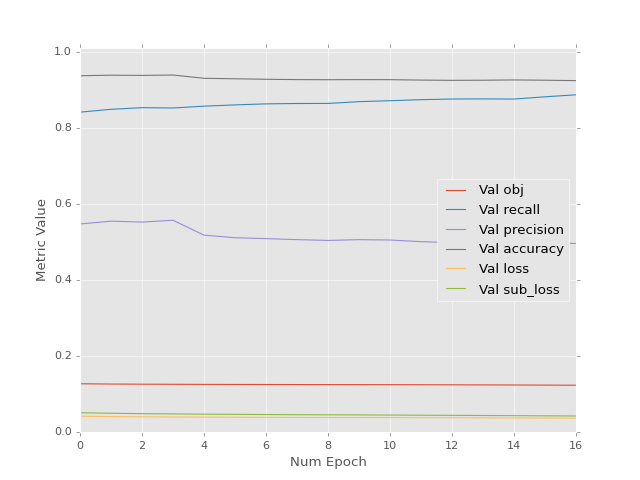

<IPython.core.display.Javascript object>


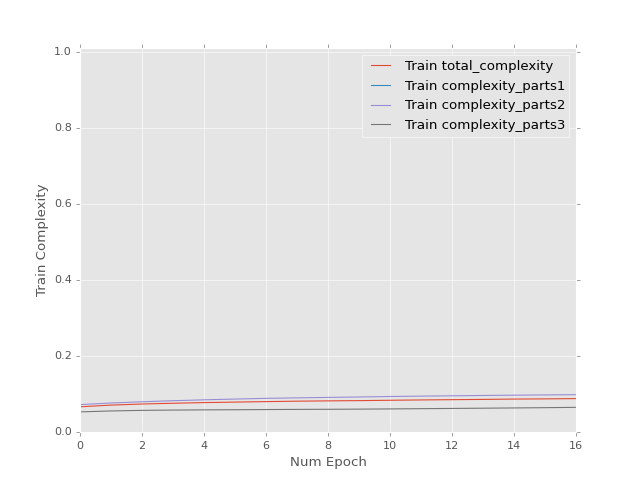

<IPython.core.display.Javascript object>


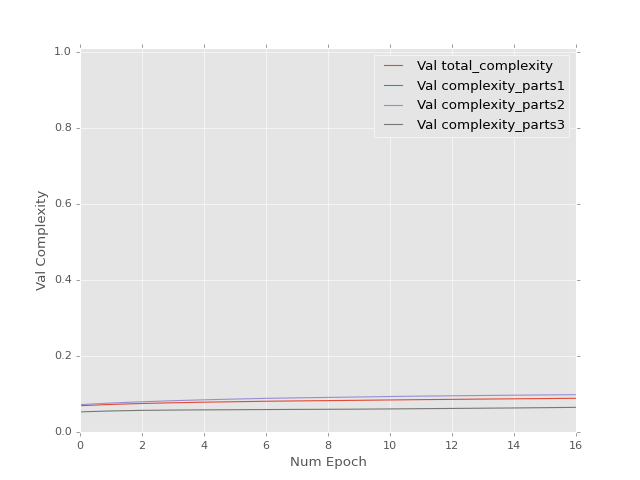

Epoch 1 of 17 took 20.302s
Epoch 2 of 17 took 20.455s
Epoch 3 of 17 took 20.514s
Epoch 4 of 17 took 20.301s
Epoch 5 of 17 took 20.448s
Epoch 6 of 17 took 20.427s
Epoch 7 of 17 took 20.359s
Epoch 8 of 17 took 20.328s
Epoch 9 of 17 took 20.313s
Epoch 10 of 17 took 20.306s
Epoch 11 of 17 took 20.404s
Epoch 12 of 17 took 20.457s
Epoch 13 of 17 took 20.433s
Epoch 14 of 17 took 20.439s
Epoch 15 of 17 took 20.324s
Epoch 16 of 17 took 20.356s
Epoch 17 of 17 took 20.357s


In [14]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=17,
      batch_size=50)

In [15]:
network.save('../weights', 'mul_big_sub_obj_complex_adjust')

# Increase the amount of cascades

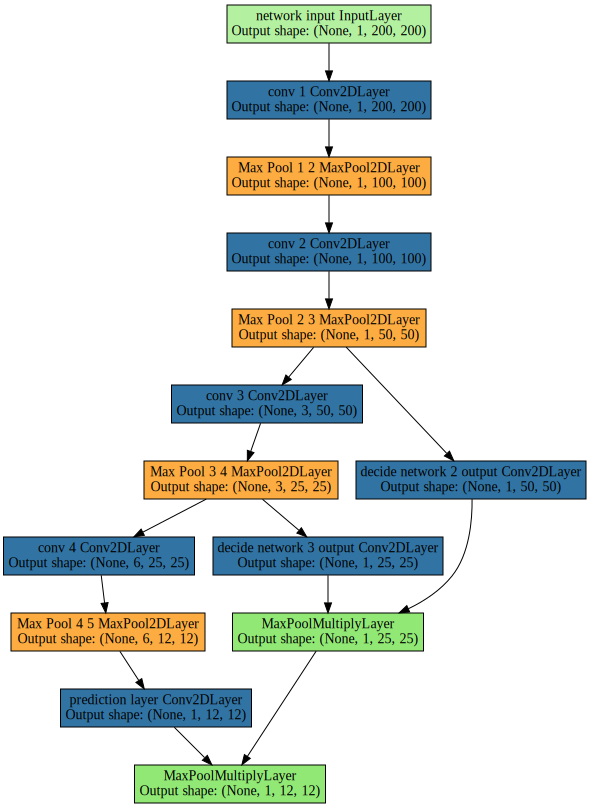

In [17]:
network = CascadeBase(img_shape=(200, 200),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[1e-2, 1e-1, 1],
                      c_sub_obj_cs=[1e-3, 1e-2, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2, 2],
                      num_filters=[1, 1, 3, 6],
                      filter_sizes=[1, 3, 3, 3])
draw(network.output_layer)

<IPython.core.display.Javascript object>


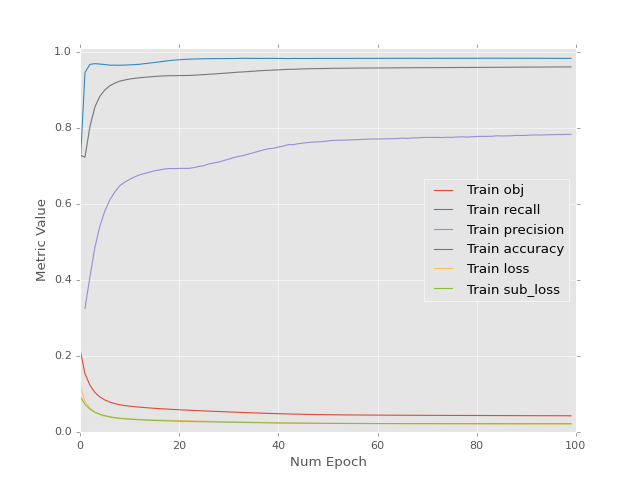

<IPython.core.display.Javascript object>


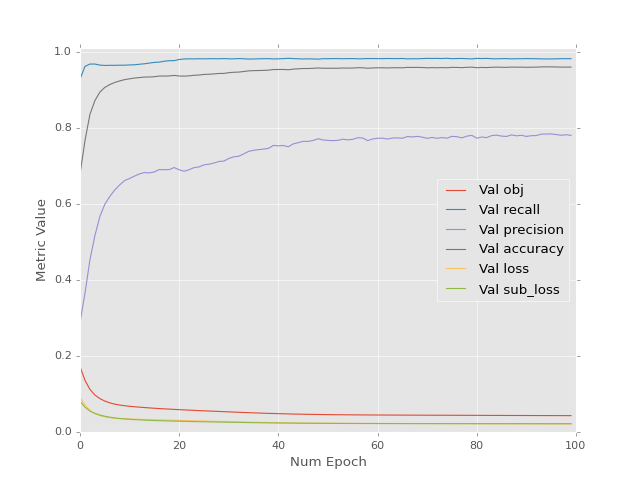

<IPython.core.display.Javascript object>


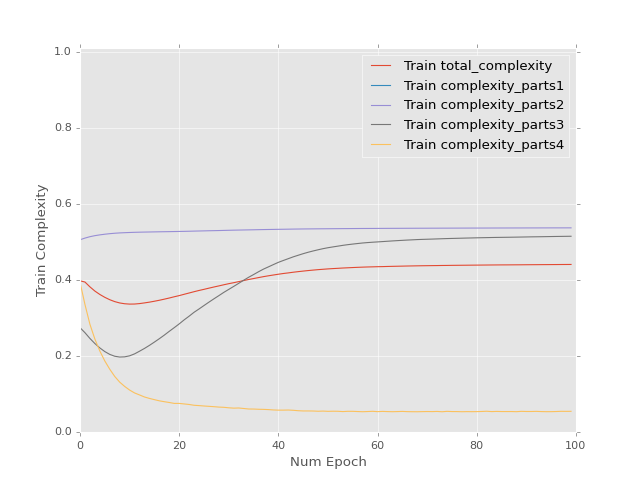

<IPython.core.display.Javascript object>


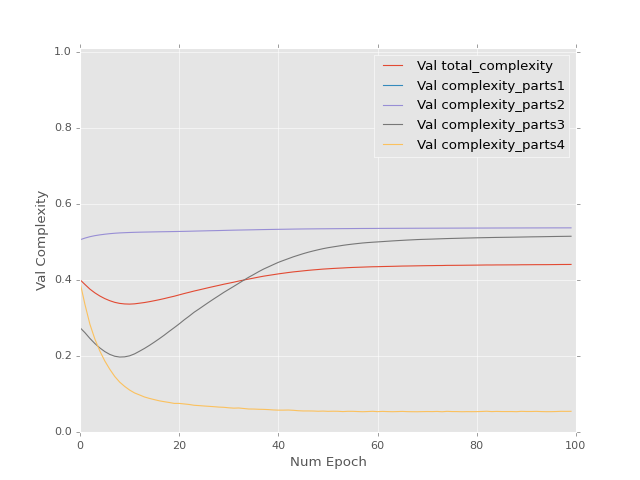

Epoch 1 of 100 took 29.291s
Epoch 2 of 100 took 29.020s
Epoch 3 of 100 took 29.197s
Epoch 4 of 100 took 29.196s
Epoch 5 of 100 took 29.222s
Epoch 6 of 100 took 29.223s
Epoch 7 of 100 took 28.971s
Epoch 8 of 100 took 29.074s
Epoch 9 of 100 took 29.250s
Epoch 10 of 100 took 29.143s
Epoch 11 of 100 took 29.190s
Epoch 12 of 100 took 29.280s
Epoch 13 of 100 took 29.157s
Epoch 14 of 100 took 28.915s
Epoch 15 of 100 took 29.016s
Epoch 16 of 100 took 29.235s
Epoch 17 of 100 took 28.928s
Epoch 18 of 100 took 29.286s
Epoch 19 of 100 took 29.272s
Epoch 20 of 100 took 29.126s
Epoch 21 of 100 took 29.318s
Epoch 22 of 100 took 29.080s
Epoch 23 of 100 took 29.173s
Epoch 24 of 100 took 29.053s
Epoch 25 of 100 took 29.167s
Epoch 26 of 100 took 29.215s
Epoch 27 of 100 took 29.086s
Epoch 28 of 100 took 29.222s
Epoch 29 of 100 took 29.232s
Epoch 30 of 100 took 29.237s
Epoch 31 of 100 took 29.344s
Epoch 32 of 100 took 29.279s
Epoch 33 of 100 took 29.249s
Epoch 34 of 100 took 29.289s
Epoch 35 of 100 took 29

In [18]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

In [19]:
network.save('../weights', '3cascades')

In [6]:
network = CascadeBase(img_shape=(200, 200),
                      learning_rate=1,
                      c=1e-1,
                      c_complexity=5e-1,
                      c_sub_objs=[1e-1, 5e-1, 1],
                      c_sub_obj_cs=[1e-2, 1e-1, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2, 2],
                      num_filters=[1, 1, 3, 6],
                      filter_sizes=[1, 3, 3, 3],
                      optimizer=lasagne.updates.nesterov_momentum)

In [7]:
network.load('../weights', '3cascades')

<IPython.core.display.Javascript object>


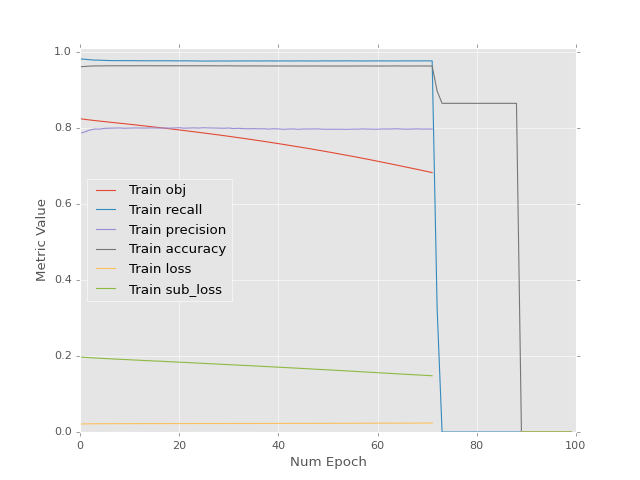

<IPython.core.display.Javascript object>


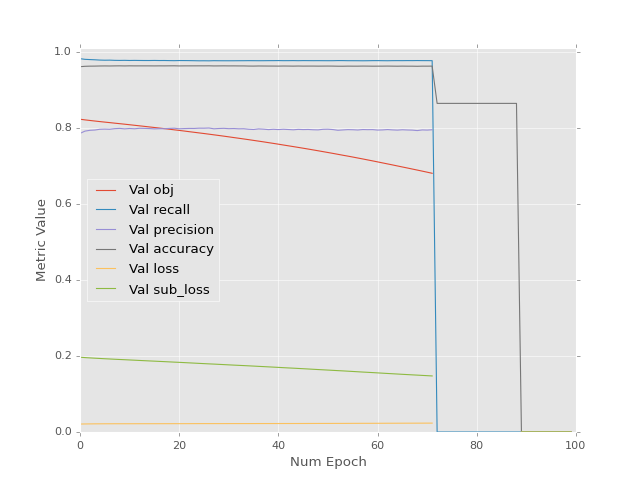

<IPython.core.display.Javascript object>


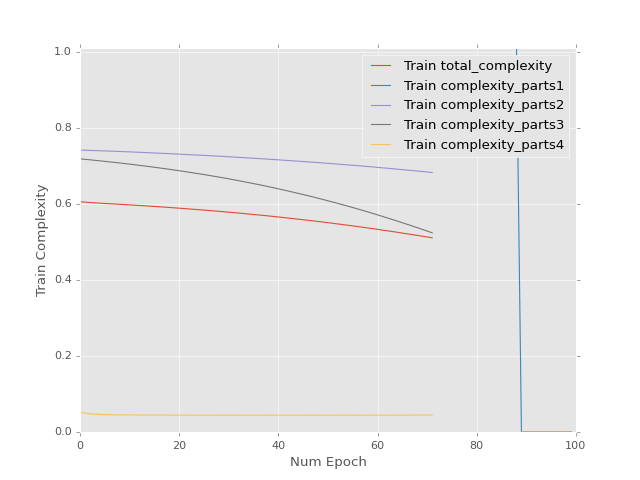

<IPython.core.display.Javascript object>


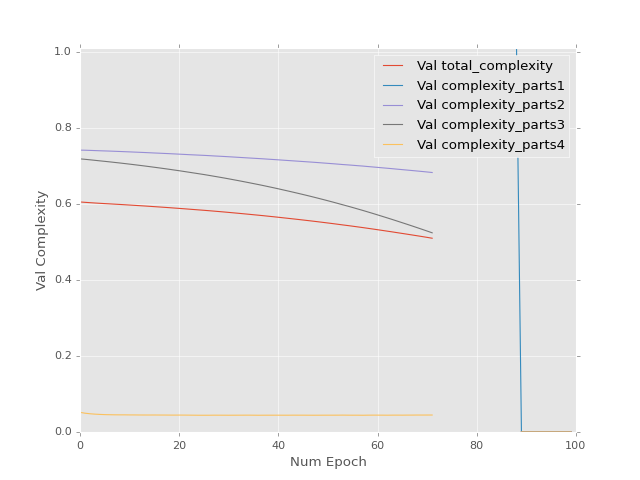

Epoch 1 of 100 took 47.130s


/home/apanin/anaconda/lib/python2.7/site-packages/matplotlib/backends/backend_webagg_core.py:210: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  buff.shape = (renderer.height, renderer.width)


Epoch 2 of 100 took 47.486s
Epoch 3 of 100 took 47.626s
Epoch 4 of 100 took 47.694s
Epoch 5 of 100 took 47.364s
Epoch 6 of 100 took 47.483s
Epoch 7 of 100 took 47.279s
Epoch 8 of 100 took 47.327s
Epoch 9 of 100 took 47.437s
Epoch 10 of 100 took 47.352s
Epoch 11 of 100 took 47.355s
Epoch 12 of 100 took 47.546s
Epoch 13 of 100 took 49.236s
Epoch 14 of 100 took 47.554s
Epoch 15 of 100 took 47.268s
Epoch 16 of 100 took 47.441s
Epoch 17 of 100 took 47.312s
Epoch 18 of 100 took 49.024s
Epoch 19 of 100 took 47.495s
Epoch 20 of 100 took 47.540s
Epoch 21 of 100 took 47.950s
Epoch 22 of 100 took 49.539s
Epoch 23 of 100 took 47.240s
Epoch 24 of 100 took 47.674s
Epoch 25 of 100 took 47.264s
Epoch 26 of 100 took 47.341s
Epoch 27 of 100 took 47.459s
Epoch 28 of 100 took 47.532s
Epoch 29 of 100 took 47.314s
Epoch 30 of 100 took 47.544s
Epoch 31 of 100 took 47.428s
Epoch 32 of 100 took 47.661s
Epoch 33 of 100 took 47.246s
Epoch 34 of 100 took 46.996s
Epoch 35 of 100 took 47.437s
Epoch 36 of 100 took 4

KeyboardInterrupt: 

In [8]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

# Check results

/home/apanin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


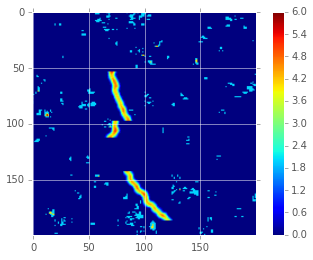

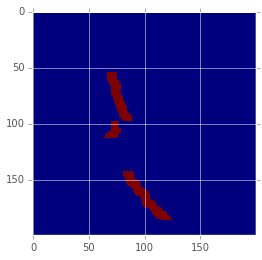

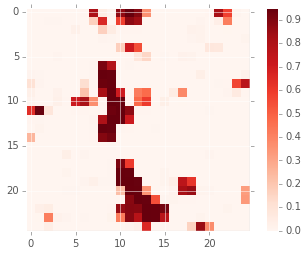

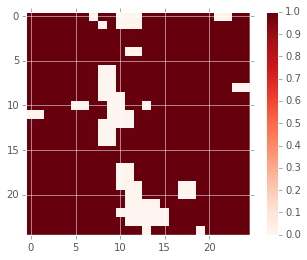

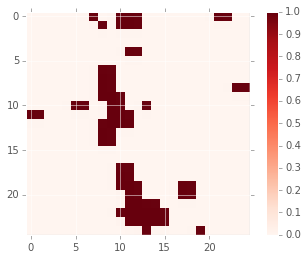

In [16]:
%matplotlib inline
i = 2

plt.imshow(X_y[1][i].reshape((200, 200)))
plt.colorbar()
plt.show()

plt.imshow(X_y[-1][i].reshape((200, 200)), interpolation='none')
plt.show()

prediction = network.predict(X_y[1][i].reshape((1, 1, 200, 200)).astype(np.float32))

plt.imshow(prediction.reshape(25, 25), interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction.reshape(25, 25) < 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction.reshape(25, 25) >= 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()